# Load libraries 

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import scipy.io
import os
import sys
from pathlib import Path
import pickle
from gc import collect
from glob import glob
from datetime import datetime
import traceback
from time import sleep
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable


#Important!! Make sure your current directory is the MHDTurbPy folder!
os.chdir("/Users/nokni/work/MHDTurbPy/")


# Make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data


""" Import manual functions """

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
import Figures as figs


# Better figures
from matplotlib import pyplot as plt
plt.style.use(['science', 'scatter'])
plt.rcParams['text.usetex'] = True

This unreleased version of SpacePy is not supported by the SpacePy team.


# Define functions

In [1]:
import numba
from joblib import Parallel, delayed

def shifted_df_calcs(B,  lag_coefs, coefs):
    """
    Used for 5-point sfuncs

    Parameters:
    B (pandas.DataFrame) : The input dataframe.
    lag_coefs (list)     : A list of integers representing the lags.
    coefs (list)         : A list of coefficients for the calculation.

    Returns:
    ndarray              : A 2D numpy array representing the result of the calculation.
    """
    return pd.DataFrame(np.add.reduce([x*B.shift(y) for x, y in zip(coefs, lag_coefs)]),
                        index=B.index, columns=B.columns).values


def flucts(tau,
           B,
           five_points_sfunc=True):
    """
    Calculate fluctuations for structure functions.

    Args:
        tau (int): Time lag.
        B (pd.Series or np.ndarray): Input field.
        five_points_sfunc (bool, optional): Estimate 5-point structure functions if True. Defaults to True.

    Returns:
        dB (np.ndarray): Fluctuations of the input field.
    """

    # Estimate 5-point Structure functions
    if five_points_sfunc:
        # Define coefs for loc fields
        coefs_loc     = np.array([1, 4, 6, 4, 1]) / 16
        lag_coefs_loc = np.array([-2 * tau, -tau, 0, tau, 2 * tau]).astype(int)

        # Define coefs for fluctuations
        coefs_db      = np.array([1, -4, +6, -4, 1]) / np.sqrt(35)
        lag_coefs_db  = np.array([-2 * tau, -tau, 0, tau, 2 * tau]).astype(int)

        # Compute the fluctuation
        dB            = shifted_df_calcs(B, lag_coefs_db, coefs_db)

    # Estimate regular 2-point Structure functions
    else:
        # Compute the fluctuation
        dB            = (B.iloc[:-tau].values - B.iloc[tau:].values)

    return dB



def structure_functions_parallel(B, scales, max_qorder, five_points_sfunc=False, keep_sdk=False, n_jobs=-1):
    """
    Estimate the structure functions of a field in parallel.

    Args:
        B (pd.Series or np.ndarray): Input field.
        scales (list or np.ndarray): Scales at which to calculate the structure functions.
        max_qorder (int): Maximum order of the structure functions to be calculated.
        five_points_sfunc (bool, optional): Estimate 5-point structure functions if True. Defaults to False.
        keep_sdk (bool, optional): Keep the SDK if True. Defaults to False.
        n_jobs (int, optional): Number of parallel jobs. Defaults to -1 (use all available cores).

    Returns:
        sfn (np.ndarray): Estimated structure functions.
        sdk (np.ndarray): Structure functions' SDK.
    """
    #
    qorders = np.arange(1, max_qorder + 1)

    def _calc_sfn(dB, qorder):
        return np.sum(np.nanmean(dB ** qorder, axis=0))

    def process_scale(tau):
        dB  = np.abs(flucts(tau, B, five_points_sfunc=five_points_sfunc))
        sfn = np.array([_calc_sfn(dB, qorder) for qorder in qorders])

        sdk = sfn.T[3] / np.sum(np.nanmean(dB ** 2, axis=0) ** 2)

        return sfn, sdk

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_scale)(tau) for tau in scales
    )

    sfn, sdk = zip(*results)

    return np.array(sfn), np.array(sdk)



# Create a dataframe with 3 components, each of which comes from a Gaussian distribution. 
 - If the code works the way it should then the Scale dependent kurtosis (K(l)) should independent of scale and equal to K(l) = 3

In [3]:
N = int(1e7)


# Creating a datetime index with a cadence of 1 second
datetime_index = pd.date_range(start='2023-03-29 00:00:00', periods=N, freq='1S')

B = pd.DataFrame({
                  'Br' : np.random.normal(loc=0, scale=1, size = N),
                  'Bt' : np.random.normal(loc=0, scale=1, size = N),
                  'Bn' : np.random.normal(loc=0, scale=1, size = N)},
                  index=datetime_index)  # Adding the datetime index to the DataFrame


taus     = 2**np.arange(1,10);

# Run main function, estimate 2-point, 5-point trace structure functions and Scale Dependent kurtosis

In [30]:
max_qorder     = 8
use_5pt_sfuncs = False # True: 5-point Sfuncs, False: 2 point Sfuncs
estimate_SDK   = True # Also keep scale dependent kurtosis

# Run main function
sfuncs, sdk = structure_functions_parallel(B,
                                          taus,
                                          max_qorder,
                                          five_points_sfunc = use_5pt_sfuncs,
                                          keep_sdk          = estimate_SDK
                                           )

# Plot Structure functions

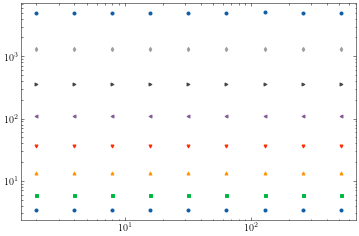

In [25]:
for i in range(max_qorder):
    plt.loglog(taus ,sfuncs.T[i])

# Plot Scale dependent kurtosis 

(2, 4)

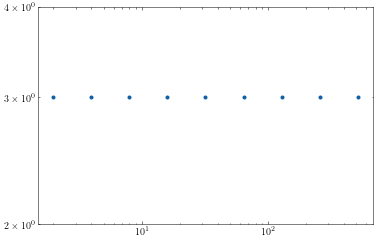

In [27]:
plt.loglog(taus, sdk)

plt.ylim([2,4])

# Check an interval from PSP

In [18]:
# Load data
import glob
fnames    = np.sort(glob.glob(str(Path('/Users/nokni/work/3d_anisotropy/structure_functions_E1/data/test_5PT_SF/').joinpath('*').joinpath('final.pkl'))))
gen_names = np.sort(glob.glob(str(Path('/Users/nokni/work/3d_anisotropy/structure_functions_E1/data/test_5PT_SF/').joinpath('*').joinpath('general.pkl'))))




# Load files
res = pd.read_pickle(fnames[0])
gen = pd.read_pickle(gen_names[0])

# Choose V, B dataframes
B  = res['Mag']['B_resampled']
V  = res['Par']['V_resampled'][['Vr', 'Vt', 'Vn']]
Np = res['Par']['V_resampled'][['np']]


Vsw = res['Par']['Vsw_mean']
di  = res['Par']['di_mean']

# Run main function 

In [19]:
max_hours      = 2
max_qorder     = 8
use_5pt_sfuncs = 1 # True: 5-point Sfuncs, False: 2 point Sfuncs
estimate_SDK   = True # Also keep scale dependent kurtosis

# Find cadence of magnetic field timeseries

dt = func.find_cadence(B)

# Define lags to estimate Sfuncs
max_lag     = int((max_hours*3600)/dt)
tau_values  = 1.2**np.arange(0, 1000)
max_ind     = (tau_values<max_lag) & (tau_values>0)
taus        = np.unique(tau_values[max_ind].astype(int))

# Run main function
sfuncs, sdk = structure_functions_parallel(B,
                                          taus,
                                          max_qorder,
                                          five_points_sfunc = use_5pt_sfuncs,
                                          keep_sdk          = estimate_SDK
                                           )

# Estimate lags in di units
ell_di = (taus*dt)*Vsw/di

/var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_72240/2526775725.py:77: RuntimeWarning: Mean of empty slice
/var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_72240/2526775725.py:77: RuntimeWarning: Mean of empty slice
/var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_72240/2526775725.py:77: RuntimeWarning: Mean of empty slice
/var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_72240/2526775725.py:77: RuntimeWarning: Mean of empty slice
/var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_72240/2526775725.py:77: RuntimeWarning: Mean of empty slice
/var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_72240/2526775725.py:77: RuntimeWarning: Mean of empty slice
/var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_72240/2526775725.py:77: RuntimeWarning: Mean of empty slice
/var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_72240/2526775725.py:77: RuntimeWarning: Mean of empty slice
/var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T

# Plot 2 point-sfuncs 

29-Mar-23 22:17:23: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
29-Mar-23 22:17:23: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
29-Mar-23 22:17:23: /var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_60509/4030181156.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([ r'$10^{1}$'])



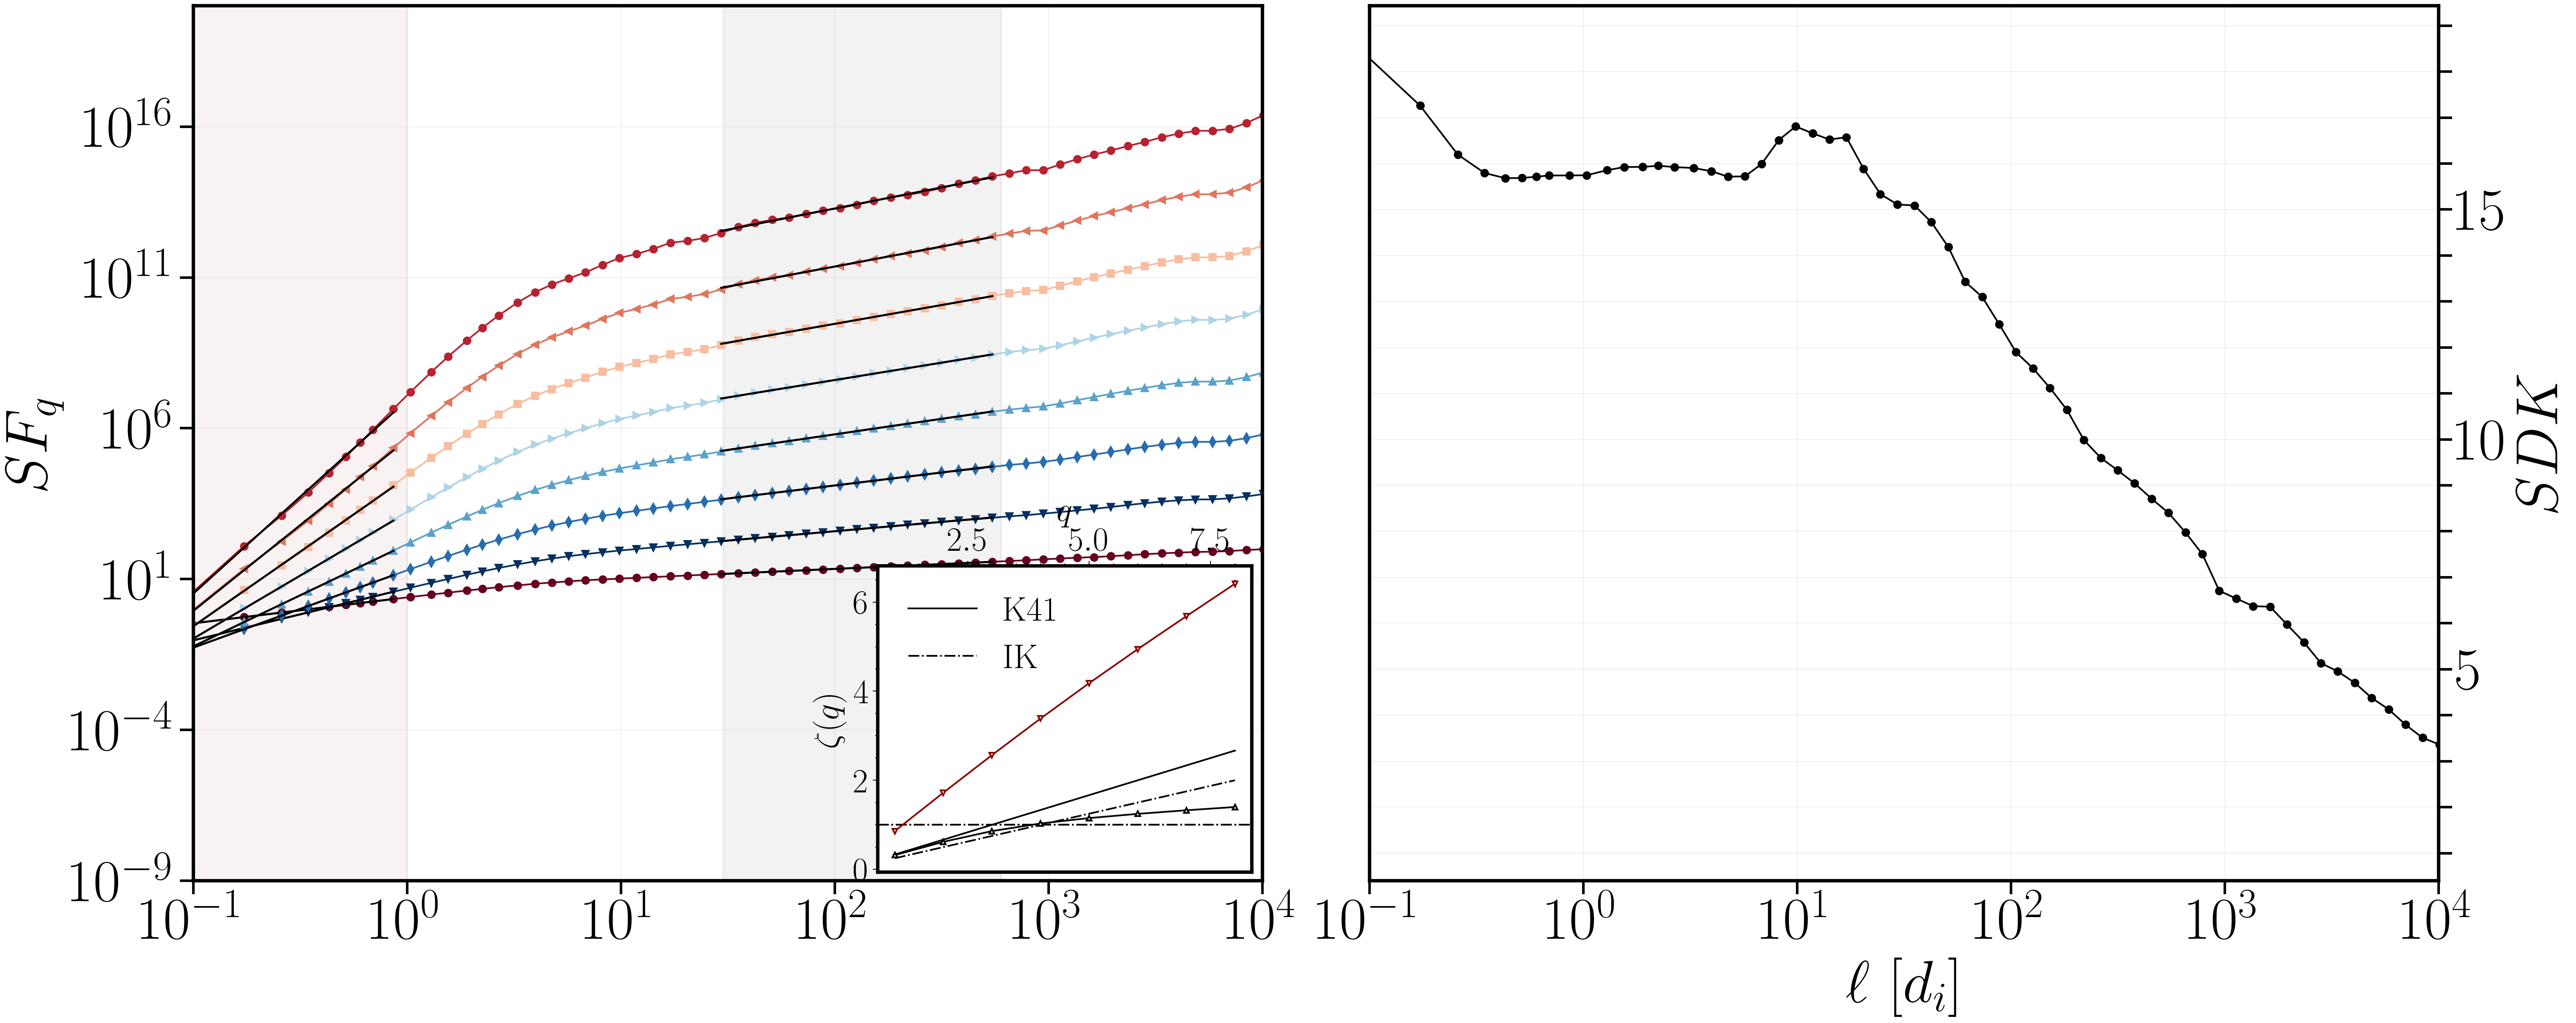

In [53]:
x01, xf1       = 30, 600
x02, xf2       = 0.1, 1


f_size         = 35
inset_f_size   = 20
xlabel, ylabel = r'$SF_q$', r'$\ell~[d_i]$'
titles         = [r'$\theta_{BV} \leq 10^{\circ}$', r'$\theta_{BV} \geq 80^{\circ}$']

ylimits        = [1e-9, 1e20]
xlimits        = [1e-1, 1e4]




#Load data

norders      = max_qorder

# Initialize figures
fig, ax                              = figs.initializeFigure_1by_2_noshare_y(xlabel, ylabel,width='1col', height=None,share_y=0)
col                                  = figs.create_colors(norders)
minor_tick_params, major_tick_params = figs.inset_axis_params(size = inset_f_size)

# IK , K41 linear scalings
x_IK, y_IK   = turb.IK_linear_scaling(norders)
x_K41, y_K41 = turb.K41_linear_scaling(norders)

for i in range(norders):
    
    # Assign Sfuncs to x,y variables
    x     = ell_di
    y     = sfuncs.T[i]


    ax[0].loglog(x,y, c=col[i-1], ms=4, ls='-')
    
    # Apply fit on two ranges on SFq
    fit1, s1, e1, x1, y1 = func.find_fit(x,y,x01,xf1)
    fit2, s2, e2, x2, y2 = func.find_fit(x,y,x02,xf2)

    lab_name =r'$\propto  \ell_{||}^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit1[0][1],2), round(np.sqrt(fit1[1][1][1]),2))
    ax[0].loglog(x1[s1:e1],fit1[2], c='k', ls='-', lw=1.2, ms=0)#,label=lab_name)
    
    lab_name =r'$\propto  \ell_{||}^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit2[0][1],2), round(np.sqrt(fit2[1][1][1]),2))
    ax[0].loglog(x2[s2:e2],fit2[2], c='k', ls='-', lw=1.2, ms=0)#,label=lab_name)


# Plot SDK
SDK = sdk
ax[1].loglog(x, SDK,c='k',  ms=4, ls='-')#,label=lab_name)

    
# Create inset  
axins2 = ax[0].inset_axes([0.64, 0.01, 0.35, 0.35])
axins2.yaxis.set_label_position("left")
axins2.xaxis.set_label_position("top")
axins2.yaxis.tick_left()
axins2.xaxis.tick_top()


for j in range(2):
    ax1=ax[j]


    fit_par =[]
    fit_per =[]
    fit_par_err =[]
    fit_per_err =[]
    if j==0:
        # Plot inset
        axins2.plot(x_K41, y_K41, c ='k', ls='-', ms=0, label ='K41')
        axins2.plot(x_IK, y_IK, c ='k', ls='-.', ms=0, label ='IK')
        
        colors         = 'k'
        xstart, xfinal = x01, xf1
    else:
        colors = 'darkred'     
        xstart, xfinal = x02, xf2
        
    for h in range(norders):
        x     = ell_di
        y     = sfuncs.T[h]

        fit1, s1, e1, x1, y1 =func.find_fit(x, y , xstart, xfinal)
        fit_par.append(fit1[0][1])
        fit_par_err.append(np.sqrt(fit1[1][1][1]))

    axins2.errorbar(x_K41, fit_par,yerr=fit_par_err,  c=colors,mfc='w', ls='-') 
    
    # Add shaded area
    ax[0].axvspan(xstart, xfinal, alpha=0.05, color=colors)
    

  
                
    # Inset axis properties
    axins2.legend(frameon=0, loc=0,ncol=1, fontsize =inset_f_size)  
    axins2.set_ylabel(r'$\zeta(q)$', fontsize =inset_f_size) 
    axins2.set_xlabel(r'$q$', fontsize =inset_f_size) 
    axins2.axhline(y=1, color ='k', ls='-.') 
    axins2.tick_params(**minor_tick_params)
    axins2.tick_params(**major_tick_params)

    # Main axis
    ax1.tick_params(axis='both', which='major',bottom=1, top=0, right=0,left=1,direction='out',labelsize=38); 
    ax1.legend(loc=2, fontsize =30, frameon=0)

    
    if j==0:
        ax[j].set_ylabel(r'$SF_q$', fontsize =f_size)

    
    # Tick parameters
    if j==0:
        ax1.tick_params(axis='both', which='major',left=1,right=0,bottom=1, top=0, direction='out',width=1.5, length=8, labelsize=f_size)
        ax1.tick_params(axis='both', which='minor',left=0,right=0,bottom=0, top=0, direction='out',width=1.5, length=8, labelsize='large')
    else:
        ax1.tick_params(axis='both', which='major',left=0,right=1,bottom=1, top=0, direction='out',width=1.5, length=8, labelsize=f_size)
        ax1.tick_params(axis='both', which='minor',left=0,right=0,bottom=0, top=0, direction='out',width=1.5, length=8, labelsize='large')
        
    ax1.xaxis.set_ticks([0.1, 1, 10, 10**2, 10**3, 10**4, 10**5, 10**6])  
    ax1.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$', r'$10^{5}$',r'$10^{6}$'])
    

    
    # Axis grids
    ax1.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.yaxis.grid(True, "major", linewidth=.1, ls='-');
    ax1.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.xaxis.grid(True, "major", linewidth=.1, ls='-');    

    ax1.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.yaxis.grid(True, "major", linewidth=.1, ls='-');
    ax1.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.xaxis.grid(True, "major", linewidth=.1, ls='-'); 
    
    # axis limits
    ax1.set_xlim(xlimits)
    if j==0:
        ax1.set_ylim(ylimits)
    
    # xlabel
    ax[1].set_xlabel(r'$\ell~[d_{i}]$', fontsize =f_size)

    
# Fix ax[1]
#ax[1].set_ylim([1, 20])
#ax[1].yaxis.set_ticks([  10])  
ax[1].set_yticklabels([ r'$10^{1}$'])
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_ylabel(r'$SDK$', fontsize =f_size)
ax[1].set_yscale('linear')

# Plot 5 point-sfuncs 

30-Mar-23 07:57:54: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
30-Mar-23 07:57:54: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
30-Mar-23 07:57:54: /var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_72240/998815444.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([ r'$10^{1}$'])



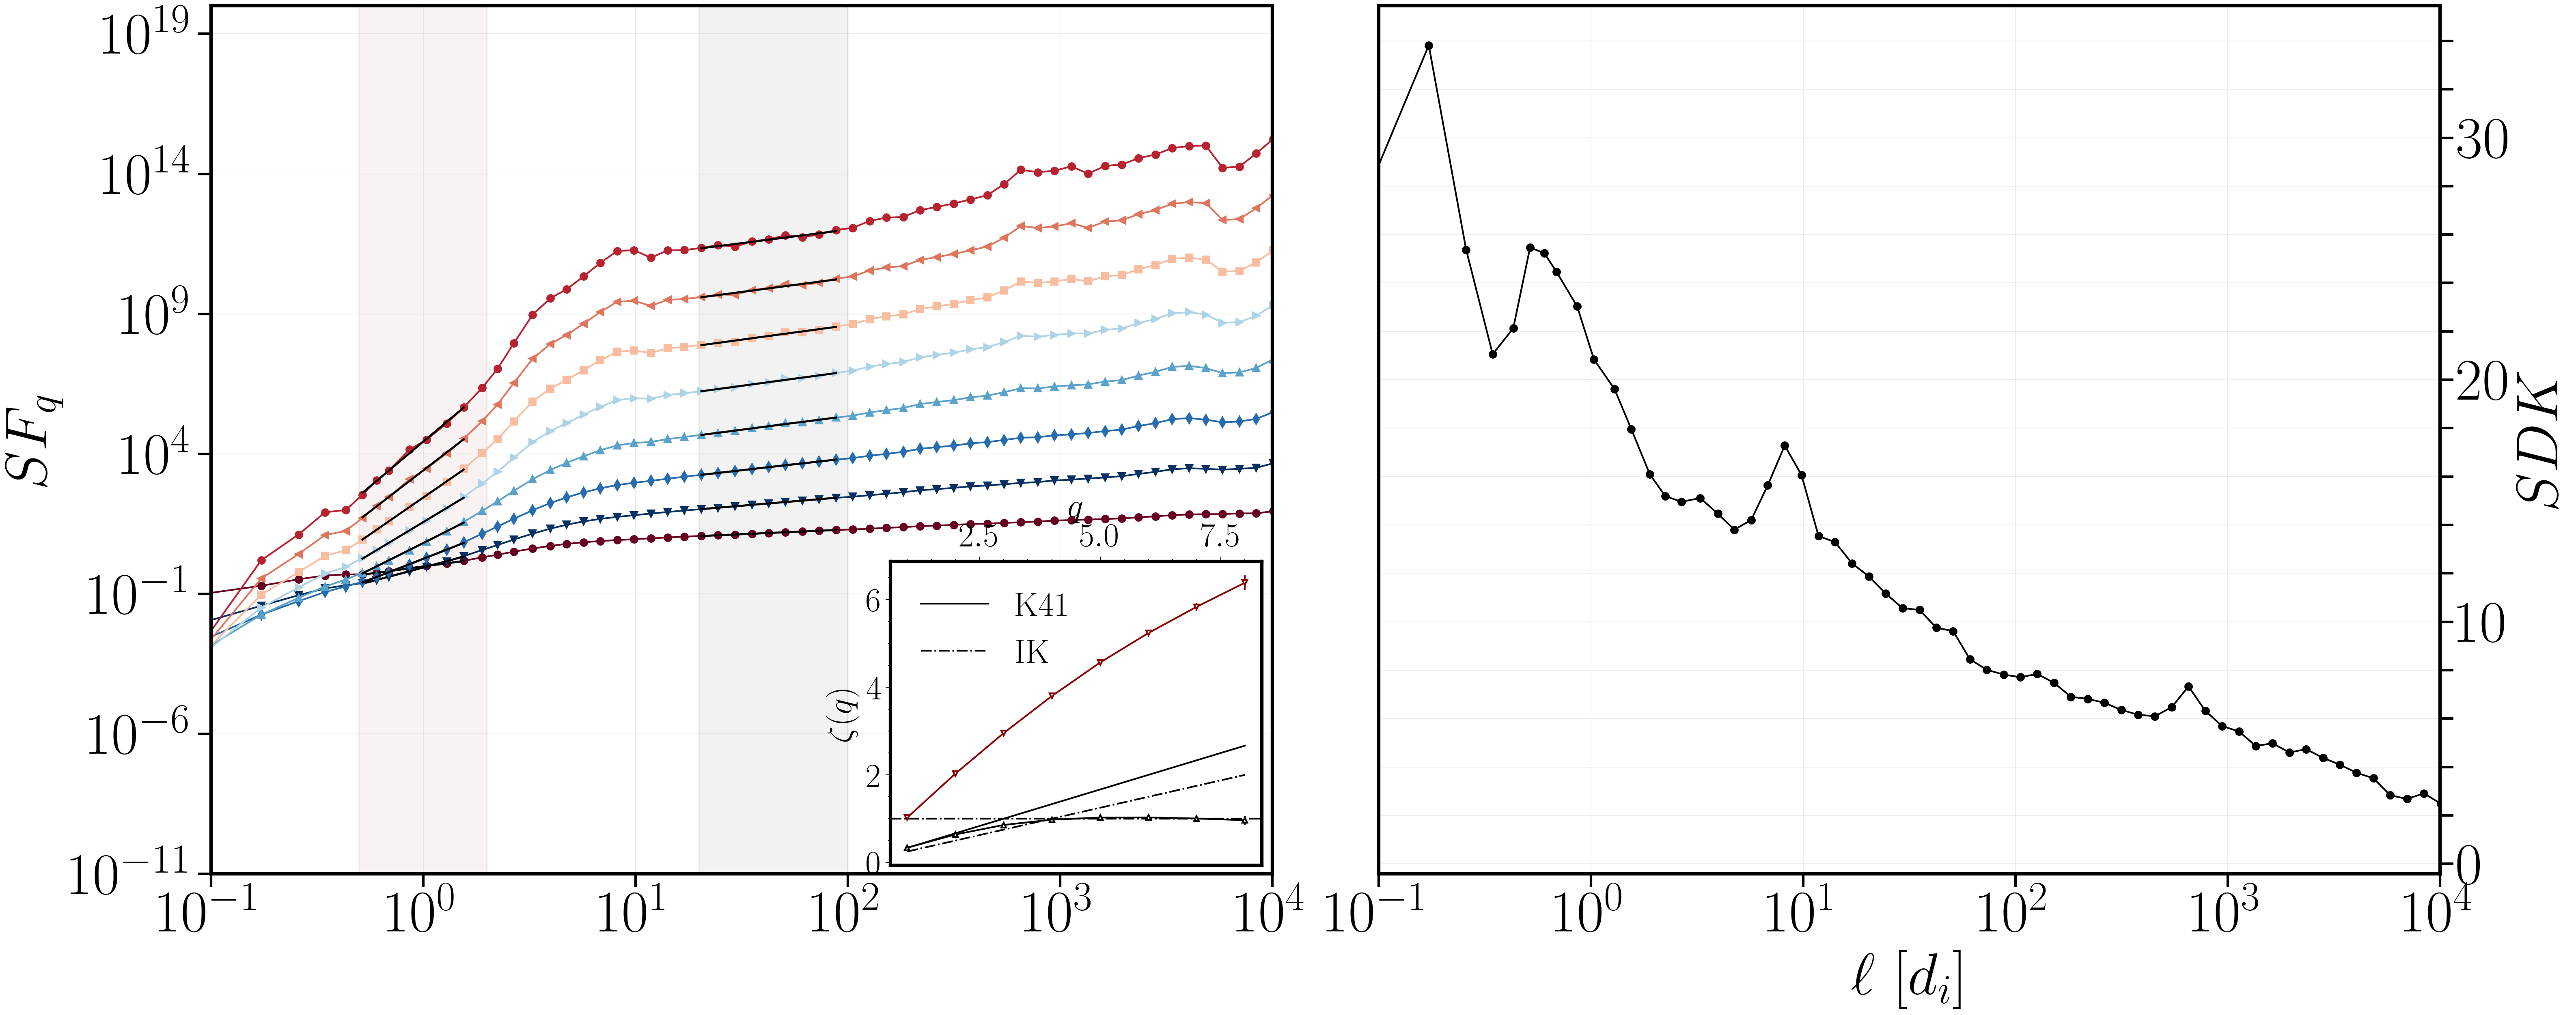

In [219]:
x01, xf1       = 20, 100
x02, xf2       = 0.5, 2


f_size         = 35
inset_f_size   = 20
xlabel, ylabel = r'$SF_q$', r'$\ell~[d_i]$'
titles         = [r'$\theta_{BV} \leq 10^{\circ}$', r'$\theta_{BV} \geq 80^{\circ}$']

ylimits        = [1e-11, 1e20]
xlimits        = [1e-1, 1e4]




#Load data

norders      = max_qorder

# Initialize figures
fig, ax                              = figs.initializeFigure_1by_2_noshare_y(xlabel, ylabel,width='1col', height=None,share_y=0)
col                                  = figs.create_colors(norders)
minor_tick_params, major_tick_params = figs.inset_axis_params(size = inset_f_size)

# IK , K41 linear scalings
x_IK, y_IK   = turb.IK_linear_scaling(norders)
x_K41, y_K41 = turb.K41_linear_scaling(norders)

for i in range(norders):
    
    # Assign Sfuncs to x,y variables
    x     = ell_di
    y     = sfuncs.T[i]


    ax[0].loglog(x,y, c=col[i-1], ms=4, ls='-')
    
    # Apply fit on two ranges on SFq
    fit1, s1, e1, x1, y1 = func.find_fit(x,y,x01,xf1)
    fit2, s2, e2, x2, y2 = func.find_fit(x,y,x02,xf2)

    lab_name =r'$\propto  \ell_{||}^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit1[0][1],2), round(np.sqrt(fit1[1][1][1]),2))
    ax[0].loglog(x1[s1:e1],fit1[2], c='k', ls='-', lw=1.2, ms=0)#,label=lab_name)
    
    lab_name =r'$\propto  \ell_{||}^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit2[0][1],2), round(np.sqrt(fit2[1][1][1]),2))
    ax[0].loglog(x2[s2:e2],fit2[2], c='k', ls='-', lw=1.2, ms=0)#,label=lab_name)


# Plot SDK
SDK = sdk
ax[1].loglog(x, SDK,c='k',  ms=4, ls='-')#,label=lab_name)

    
# Create inset  
axins2 = ax[0].inset_axes([0.64, 0.01, 0.35, 0.35])
axins2.yaxis.set_label_position("left")
axins2.xaxis.set_label_position("top")
axins2.yaxis.tick_left()
axins2.xaxis.tick_top()


for j in range(2):
    ax1=ax[j]


    fit_par =[]
    fit_per =[]
    fit_par_err =[]
    fit_per_err =[]
    if j==0:
        # Plot inset
        axins2.plot(x_K41, y_K41, c ='k', ls='-', ms=0, label ='K41')
        axins2.plot(x_IK, y_IK, c ='k', ls='-.', ms=0, label ='IK')
        
        colors         = 'k'
        xstart, xfinal = x01, xf1
    else:
        colors = 'darkred'     
        xstart, xfinal = x02, xf2
        
    for h in range(norders):
        x     = ell_di
        y     = sfuncs.T[h]

        fit1, s1, e1, x1, y1 =func.find_fit(x, y , xstart, xfinal)
        fit_par.append(fit1[0][1])
        fit_par_err.append(np.sqrt(fit1[1][1][1]))

    axins2.errorbar(x_K41, fit_par,yerr=fit_par_err,  c=colors,mfc='w', ls='-') 
    
    # Add shaded area
    ax[0].axvspan(xstart, xfinal, alpha=0.05, color=colors)
    

  
                
    # Inset axis properties
    axins2.legend(frameon=0, loc=0,ncol=1, fontsize =inset_f_size)  
    axins2.set_ylabel(r'$\zeta(q)$', fontsize =inset_f_size) 
    axins2.set_xlabel(r'$q$', fontsize =inset_f_size) 
    axins2.axhline(y=1, color ='k', ls='-.') 
    axins2.tick_params(**minor_tick_params)
    axins2.tick_params(**major_tick_params)

    # Main axis
    ax1.tick_params(axis='both', which='major',bottom=1, top=0, right=0,left=1,direction='out',labelsize=38); 
    ax1.legend(loc=2, fontsize =30, frameon=0)

    
    if j==0:
        ax[j].set_ylabel(r'$SF_q$', fontsize =f_size)

    
    # Tick parameters
    if j==0:
        ax1.tick_params(axis='both', which='major',left=1,right=0,bottom=1, top=0, direction='out',width=1.5, length=8, labelsize=f_size)
        ax1.tick_params(axis='both', which='minor',left=0,right=0,bottom=0, top=0, direction='out',width=1.5, length=8, labelsize='large')
    else:
        ax1.tick_params(axis='both', which='major',left=0,right=1,bottom=1, top=0, direction='out',width=1.5, length=8, labelsize=f_size)
        ax1.tick_params(axis='both', which='minor',left=0,right=0,bottom=0, top=0, direction='out',width=1.5, length=8, labelsize='large')
        
    ax1.xaxis.set_ticks([0.1, 1, 10, 10**2, 10**3, 10**4, 10**5, 10**6])  
    ax1.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$', r'$10^{5}$',r'$10^{6}$'])
    

    
    # Axis grids
    ax1.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.yaxis.grid(True, "major", linewidth=.1, ls='-');
    ax1.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.xaxis.grid(True, "major", linewidth=.1, ls='-');    

    ax1.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.yaxis.grid(True, "major", linewidth=.1, ls='-');
    ax1.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.xaxis.grid(True, "major", linewidth=.1, ls='-'); 
    
    # axis limits
    ax1.set_xlim(xlimits)
    if j==0:
        ax1.set_ylim(ylimits)
    
    # xlabel
    ax[1].set_xlabel(r'$\ell~[d_{i}]$', fontsize =f_size)

    
# Fix ax[1]
#ax[1].set_ylim([1, 20])
#ax[1].yaxis.set_ticks([  10])  
ax[1].set_yticklabels([ r'$10^{1}$'])
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_ylabel(r'$SDK$', fontsize =f_size)
ax[1].set_yscale('linear')

# Now experiment with wavelet structure functions 

# Same gaussian distribution as before

In [299]:
N = int(1e5)


# Creating a datetime index with a cadence of 1 second
datetime_index = pd.date_range(start='2023-03-29 00:00:00', periods=N, freq='1S')

B = pd.DataFrame({
                  'Br' : np.random.normal(loc=0, scale=1, size = N),
                  'Bt' : np.random.normal(loc=0, scale=1, size = N),
                  'Bn' : np.random.normal(loc=0, scale=1, size = N)},
                  index=datetime_index)  # Adding the datetime index to the DataFrame
V = pd.DataFrame({
                  'Vr' : np.random.normal(loc=0, scale=1, size = N),
                  'Vt' : np.random.normal(loc=0, scale=1, size = N),
                  'Vn' : np.random.normal(loc=0, scale=1, size = N)},
                  index=datetime_index)  # Adding the datetime index to the DataFrame

B_df                   = B
V_df                   = V


# Morlet wavelet parameters
dj                     = 1/2
per_thresh, par_thresh = 0, 0.1

# Estimate cadence of mag field timeseries
dt                     = func.find_cadence(B_df)

# Estimate morlet-wavelet PSD. Also decompose into perp, parallel spectrumn
db_x, db_y, db_z, angles, VBangles, freqs, PSD, phys_scales, scales  = turb.estimate_wavelet_coeff(B_df,
                                                                                                   V_df, 
                                                                                                   dj , 
                                                                                                   lambdaa= 3 ,
                                                                                                   pycwt  = False
                                                                                                     )
# Estimate perp and par spectra
PSD_par, PSD_per                                        = turb.estimate_anisotropic_PSD_wavelets(  db_x, 
                                                                                                   db_y, 
                                                                                                   db_z, 
                                                                                                   VBangles.values, 
                                                                                                   freqs,   
                                                                                                   dt,  
                                                                                                   per_thresh, 
                                                                                                   par_thresh
                                                                                                  )